In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [113]:
import sys

sys.path.insert(0, "../")

import torch
import os
import time
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from easydict import EasyDict

import options
from rl.explore import epsilon_greedy_gc
from data.dataset import InMemorySokobanDataset
from data.graph_env import GraphEnv
from data.utils import display_graph, direction_to_node_idx, plot_history
from model.graph_centered import GraphCenteredNet, GraphCenteredNetV2
from rl.qlearning_trainer_gc import QLearningGraphCenteredTrainer
from data.embedding import (
    DirectionalPositionalEmbedding,
    FullyConnectedPositionalEmbedding,
)


def load(fname):
    with open(os.path.join(LOGS_PATH, fname), "rb") as f:
        return pickle.load(f)

<IPython.core.display.Javascript object>

## Monitor history training

In [99]:
LOGS_PATH = "../logs/6x6_depth3/"

eval_history = load("eval_history.pkl")
train_history = load("train_history.pkl")

<IPython.core.display.Javascript object>

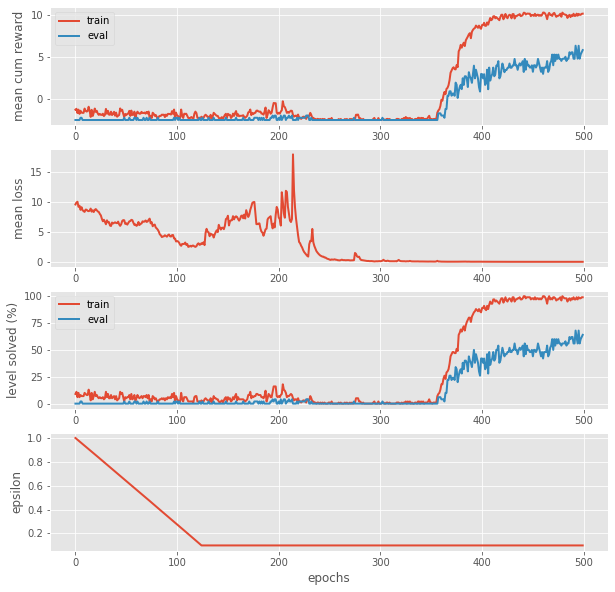

<IPython.core.display.Javascript object>

In [100]:
plot_history(train_history, eval_history)

## Try trained models on levels

In [120]:
levels_path = "../levels/6x61/test/"
weights_path = "../logs/6x6_depth3/weigths.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_message_passing = 5
hiddens = 256
max_steps = 25

<IPython.core.display.Javascript object>

In [121]:
# Load and transform levels into graphs
embedding = DirectionalPositionalEmbedding()
dataset = InMemorySokobanDataset(levels_path, embedding, device)

# Setup the environment
env = GraphEnv(embedding, device)

<IPython.core.display.Javascript object>

In [124]:
# Build the correct model (see in the logs if you don't remeber)
policy_net = GraphCenteredNetV2(
    embedding.NUM_NODES_FEATURES,
    None,
    num_message_passing=num_message_passing,
    hiddens=hiddens,
    aggr="max",
    device=device,
).to(device)
print(policy_net)

# load weights
policy_net.load_state_dict(torch.load(weights_path))

GraphCenteredNetV2(
  (conv_e): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  ))
  (conv_c): Sequential(
    (0): EdgeConv(nn=Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
    (1): EdgeConv(nn=Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
    (2): EdgeConv(nn=Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
    (3): EdgeConv(nn=Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
    (4): EdgeConv(nn=Sequential(

<All keys matched successfully>

<IPython.core.display.Javascript object>

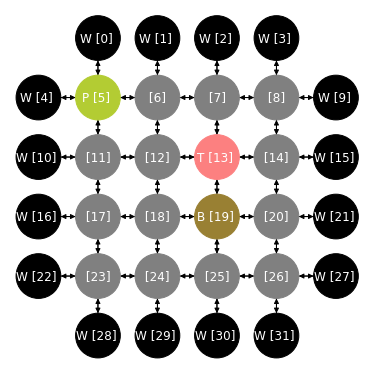

down
11


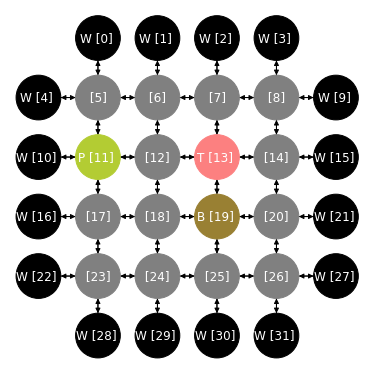

down
17


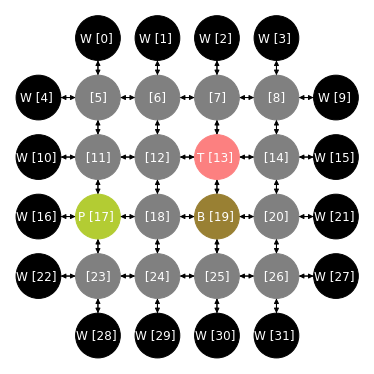

right
18


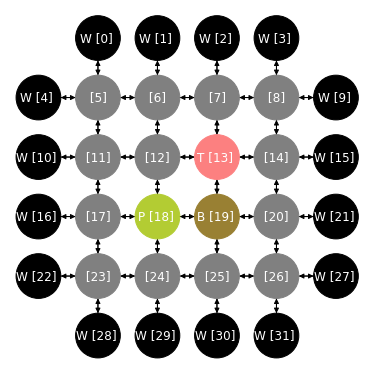

down
24


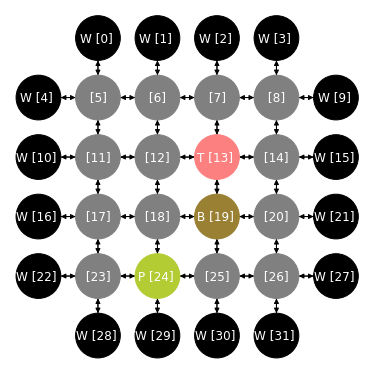

right
25


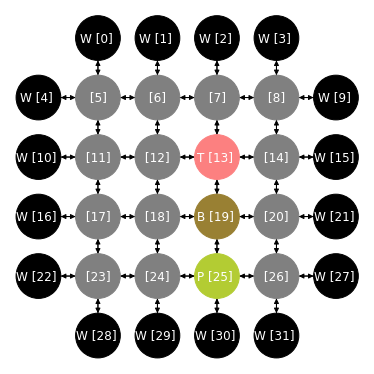

up
19


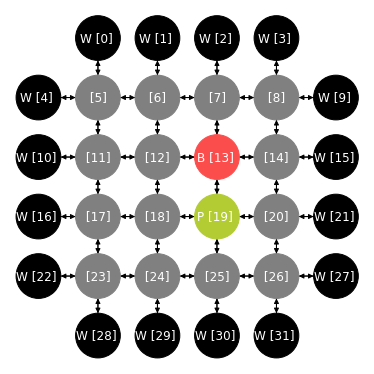

right
20


<IPython.core.display.Javascript object>

In [125]:
# Visualize some levels
actions = {0: "up", 1: "down", 2: "left", 3: "right"}
lvl_idx = 0

with torch.no_grad():
    # Initialize the environment and state
    env.reset(dataset[lvl_idx])

    for t in range(max_steps):
        state = env.render().to(device)

        # Plot the state
        plt.figure(figsize=(5, 5))
        display_graph(state, node_size=2000)
        plt.show()

        # Select and perform an action (without exploration, eps=0)
        scores, _, _ = policy_net(
            x=state.x,
            edge_index=state.edge_index,
            edge_attr=state.edge_attr,
            u=None,
            batch=None,
        )
        action = torch.argmax(scores, dim=-1)

        print(actions[action.item()])
        action_node = direction_to_node_idx(state, action)
        print(action_node.item())

        # Observe new state
        next_state, reward, done, info = env.step(action_node)

        if done:
            break